# Linear Regression #

In this notebook we will:

- Use nearest neighbors prediction as stepping stone toward regression
- Learn how to use the `scipy.stats.linregress` to run a linear regression
- Learn how to interpret and report the results of a linear regression

We will delve into the mathematics involved in defining the linear regression line in another notebook. 

In [1]:
# HIDDEN
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

import scipy.stats as stats

# Some functions for plotting. You don't have to understand how any
# of the functions in this cell work, since they use things we 
# haven't learned about in Data 8.


def resize_window(lim=3.5):
    plots.xlim(-lim, lim)
    plots.ylim(-lim, lim)
    
def draw_line(slope=0, intercept=0, x=make_array(-4, 4), color='r'):
    y = x*slope + intercept
    plots.plot(x, y, color=color)
    
def draw_vertical_line(x_position, color='black'):
    x = make_array(x_position, x_position)
    y = make_array(-4, 4)
    plots.plot(x, y, color=color)
    
def make_correlated_data(r):
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r*x + (np.sqrt(1-r**2))*z
    return x, y

def r_scatter(r):
    """Generate a scatter plot with a correlation approximately r"""
    plots.figure(figsize=(5,5))
    x, y = make_correlated_data(r)
    plots.scatter(x, y, color='darkblue', s=20)
    plots.xlim(-4, 4)
    plots.ylim(-4, 4)
    
def r_table(r):
    """
    Generate a table of 1000 data points with a correlation approximately r
    """
    np.random.seed(8)
    x, y = make_correlated_data(r)
    return Table().with_columns('x', x, 'y', y)

from IPython.core.display import display, HTML
toggle_code_str = '''
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Hide/Show Code (Too Advanced or Not the Point)"></form>
'''

toggle_code_prepare_str = '''
    <script>
    function code_toggle() {
        if ($('div.cell.code_cell.rendered.selected div.input').css('display')!='none'){
            $('div.cell.code_cell.rendered.selected div.input').hide();
        } else {
            $('div.cell.code_cell.rendered.selected div.input').show();
        }
    }
    </script>

'''

display(HTML(toggle_code_prepare_str + toggle_code_str))

def hide_code():
    display(HTML(toggle_code_str))

from IPython.core.display import display, HTML
toggle_code_str2 = '''
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Figure Code"></form>
'''

toggle_code_prepare_str2 = '''
    <script>
    function code_toggle() {
        if ($('div.cell.code_cell.rendered.selected div.input').css('display')!='none'){
            $('div.cell.code_cell.rendered.selected div.input').hide();
        } else {
            $('div.cell.code_cell.rendered.selected div.input').show();
        }
    }
    </script>

'''

#display(HTML(toggle_code_prepare_str2 + toggle_code_str2))

def hide_code_figure():
    display(HTML(toggle_code_str2))
    

## Prediction ##

Nearest neighbors predictions

In [87]:
births = Table.read_table('baby.csv')
births.relabel("Maternal Pregnancy Weight", "Mother Weight")
births.show(5)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False


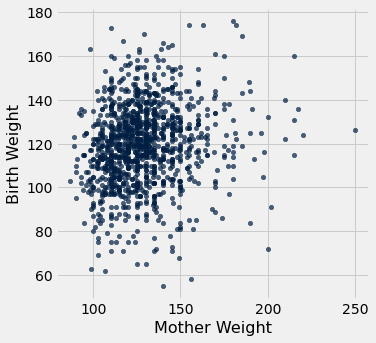

In [88]:
births.select("Mother Weight","Birth Weight").scatter("Mother Weight")

In [124]:
halfwidth = 1  ## Vary the halfwidth of the ribbon for the nearest neighbors to see how the prediction changes

def nn_prediction_example(x_val):
    """ Predicts y-value for x based on the example table """
    neighbors = births.where('Mother Weight', are.between(x_val - halfwidth, x_val + halfwidth))
    return np.mean(neighbors.column('Birth Weight'))

In [125]:
nn_prediction_example(135)

118.61764705882354

In [129]:
births = births.with_columns(
    'Pred Birth Weight', 
    births.apply(nn_prediction_example, 'Mother Weight'))

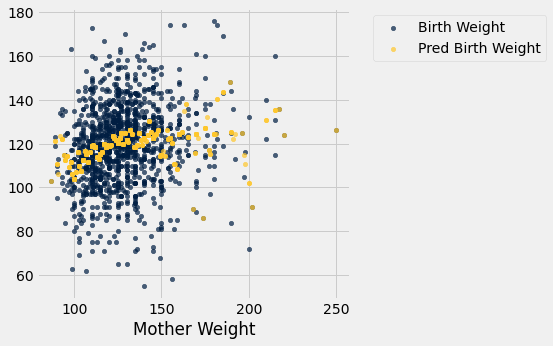

In [130]:
births.select('Mother Weight', 'Birth Weight', 'Pred Birth Weight').scatter('Mother Weight')

In [58]:
sat2014 = Table.read_table('sat2014.csv').sort('State')
sat2014.show(5)

State,Participation Rate,Critical Reading,Math,Writing,Combined
Alabama,6.7,547,538,532,1617
Alaska,54.2,507,503,475,1485
Arizona,36.4,522,525,500,1547
Arkansas,4.2,573,571,554,1698
California,60.3,498,510,496,1504


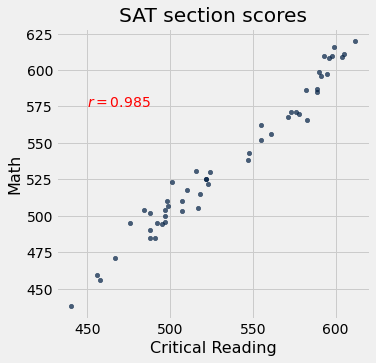

In [59]:
sat2014.scatter('Critical Reading', 'Math')
plots.text(450, 575, "$r = 0.985$", color='red')
plots.title("SAT section scores");

In [116]:
def nn_prediction_example(x_val):
    """ Predicts y-value for x based on the example table """
    neighbors = sat2014.where('Critical Reading', are.between(x_val - 10, x_val + 10))
    return np.mean(neighbors.column('Math'))
    

In [117]:
nn_prediction_example(522)

521.8571428571429

In [118]:
sat2014 = sat2014.with_columns(
    'Predicted Math', 
    sat2014.apply(nn_prediction_example, 'Critical Reading'))

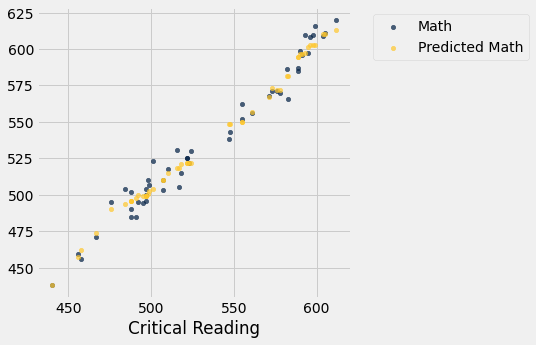

In [119]:
sat2014.select('Critical Reading', 'Math','Predicted Math').scatter('Critical Reading')


In [135]:
example = r_table(0.5)

def nn_prediction_example(x_val):
    """ Predicts y-value for x based on the example table """
    neighbors = example.where('x', are.between(x_val - .25, x_val + .25))
    return np.mean(neighbors.column('y'))

example = example.with_columns(
    'Predicted y', 
    example.apply(nn_prediction_example, 'x'))

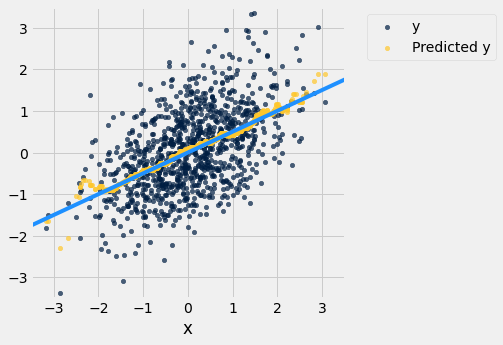

In [136]:
example.scatter('x')
draw_line(slope=.5, color='dodgerblue')
resize_window()

## Linear Regression Equation ##

The goal here is to have a reliable technique for finding an equation for the line we see in light blue above.  That method is known as linear regression.  

## Linear regression: cutting to the end


If the following equation is used to predict values of $y$ from values of $x$

$$\hat{y} = b_1x +b_0$$ 


Then $$b_1 = r \frac{S_y}{S_x}$$

Also this line always passes through the point $(\overline{x}, \overline{y})$.

From the two facts above we can determine that:

$$ \begin{array}{rl}b_0&= \overline{y} - b_1\overline{x} \\ &\displaystyle = \overline{y} - r \frac{S_y}{S_x}\overline{x} \end{array}$$

Naturally, there is a command that gives us all that plus more information:  `linregress` in the `scipy.stats` module.


In [37]:
import scipy.stats

sat2014 = Table.read_table('sat2014.csv')

scipy.stats.linregress(sat2014.column("Critical Reading"), sat2014.column("Math"))

LinregressResult(slope=0.9921355234946511, intercept=7.3617361832913275, rvalue=0.9847558411067429, pvalue=6.932520070006056e-39, stderr=0.02503511969481054)

In [38]:
scipy.stats.pearsonr(sat2014.column("Critical Reading"), sat2014.column("Math"))

(0.9847558411067433, 6.932520070001197e-39)

The equation is $\hat{y} = 0.99 x + 7.36$



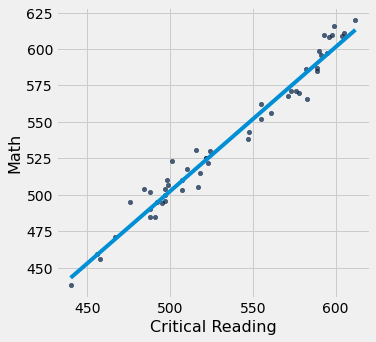

In [47]:
def reg_line(x):
    return 0.99*x + 7.36

sat2014.scatter("Critical Reading", "Math")
plots.plot([440, 612],[reg_line(440),reg_line(612)]);

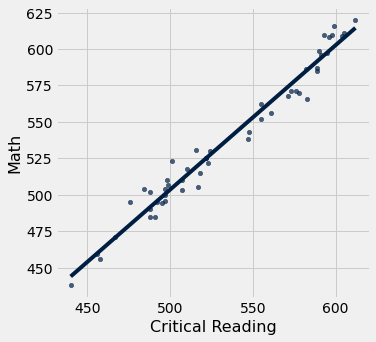

In [48]:
sat2014.scatter("Critical Reading", "Math", fit_line=True)

Recall that `scipy.stats.pearsonr` includes a p-value for a hypothesis test with hypotheses

$H_o: \rho = 0$

$H_a: \rho \not = 0$

This is **equivalent** to a test with these hypotheses

$H_o: \beta_1 = 0$

$H_a: \beta_1 \not = 0$

Furthermore, the `scipy.stats.linregress` command runs this equivalent hypothesis test.  That's what the p-value reported with the linregress output is.  

Remember that the slope of the regression line is $\displaystyle b_1 = r \frac{S_y}{S_x}$.  So if we assume $r= 0$ then $b_1 = 0$, too.  

If we assume that $b_1 = 0$, that means that either $r = 0$ or $S_y = 0$.  The only way $S_y = 0$ is if the data forms a vertical line, which we'd see in the scatterplot, and we already discussed that makes $r$ undefined.    

### Reporting Out ###

#### The regression equation is that $\hat{\mathrm{Math}} = 0.99 \cdot \mathrm{Reading} + 7.86$; the correlation is 0.985, both the correlation and the slope of the regression line are significantly different from 0 (p =0.007).  See Figure 1 below.  ###


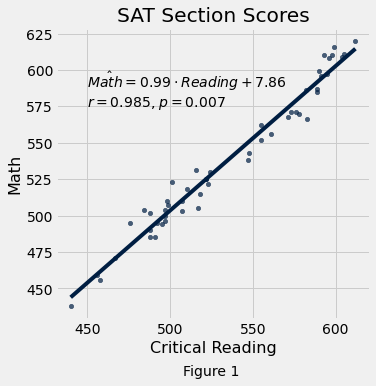

In [163]:
sat2014.scatter("Critical Reading", "Math", fit_line=True)
plots.title("SAT Section Scores")
plots.text(450, 575, "$\hat{Math} = 0.99\cdot Reading + 7.86$\n$r = 0.985$, $p  =0.007$")
plots.text(525, 390, "Figure 1", ha='center');

hide_code_figure()

## Galton height data

In [143]:
galton = Table.read_table('galton.csv')

heights = Table().with_columns(
    'MidParent', galton.column('midparentHeight'),
    'Child', galton.column('childHeight'))
heights

MidParent,Child
75.43,73.2
75.43,69.2
75.43,69
75.43,69
73.66,73.5
73.66,72.5
73.66,65.5
73.66,65.5
72.06,71
72.06,68


In [144]:
def nn_prediction_galton(h):
    """Return a prediction of the height of a child 
    whose parents have a midparent height of h.
    
    The prediction is the average height of the children 
    whose midparent height is in the range h plus or minus 0.5 inches.
    """
    neighbors = heights.where(
        'MidParent', are.between(h - 0.5, h + 0.5))
    return np.mean(neighbors.column('Child'))

In [151]:
heights_with_predictions = heights.with_column(
    'Average neighbor prediction', 
    heights.apply(nn_prediction_galton, 'MidParent'))

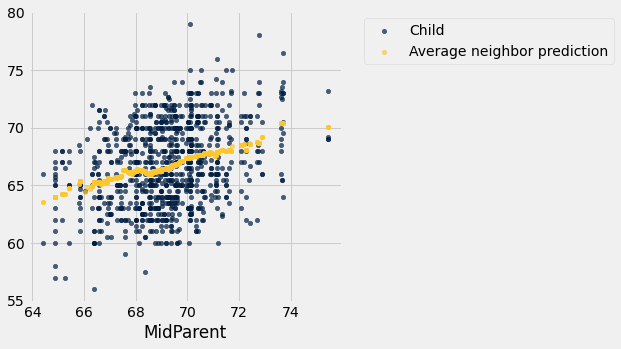

In [152]:
heights_with_predictions.scatter('MidParent')

In [150]:
stats.linregress(heights.column('MidParent'), heights.column('Child'))

LinregressResult(slope=0.6373608969694791, intercept=22.636240549589736, rvalue=0.3209498960639595, pvalue=8.053864992478921e-24, stderr=0.06160760165644823)

### Reporting Out ###

#### The predicted childs height is given by $\hat{Child} = 0.94\cdot MidParent + 22.64$ and the correlation between child height and midparent height is 0.32.  At the 5% level, the slope and the correlation are not significantly different from 0 with p = 0.08.  See Figure 1 below.  ####

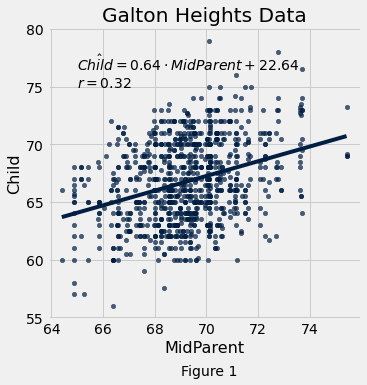

In [164]:
heights.scatter('MidParent', fit_line=True)
plots.text(65, 75, "$\hat{Child} = 0.64\cdot MidParent + 22.64$\n$r=0.32$, $p = 0.08")
plots.title("Galton Heights Data")
plots.text(69,50,"Figure 1");

hide_code_figure()